## 0. Getting setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")

torch version: 2.2.2
torchvision version: 0.17.2


In [5]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
except:
    print("[INFO] Couldn't find going_modular script")
try:
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print(f"[INFO] Couldn't find helper_functions")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get Data

In [7]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [9]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manualy created transforms: {manual_transforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x764dda6431d0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
image_batch, label_batch =  next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

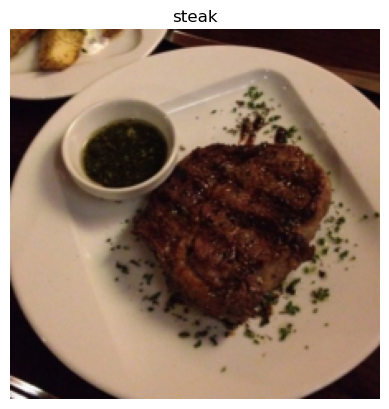

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [13]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
print(f"NUmber of patches (N) with image height (H={height}), width (W={width}) and patch_size (P={patch_size})")

NUmber of patches (N) with image height (H=224), width (W=224) and patch_size (P=16)


* Input: The image starts as 2D with H x W x C
* Output: The image gets converted to a sequence of fllatened 2D patches with size N x (P^2 * C)

In [14]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (singel 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (singel 2D image flattened into patches): (196, 768)


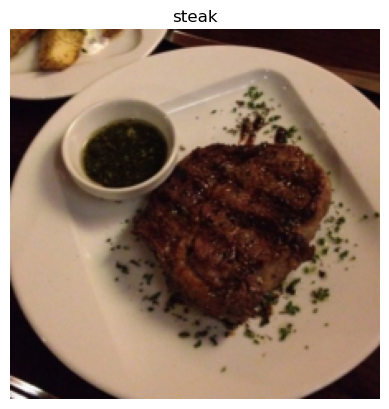

In [16]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

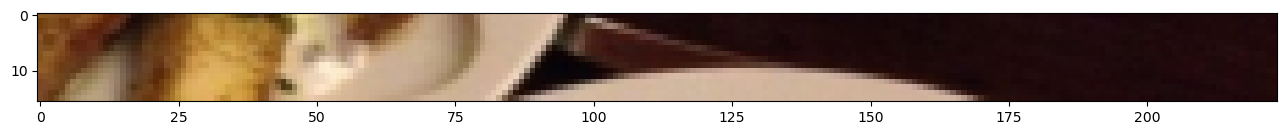

In [17]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


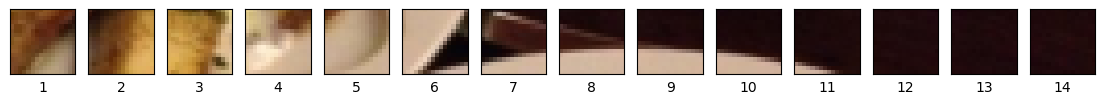

In [24]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


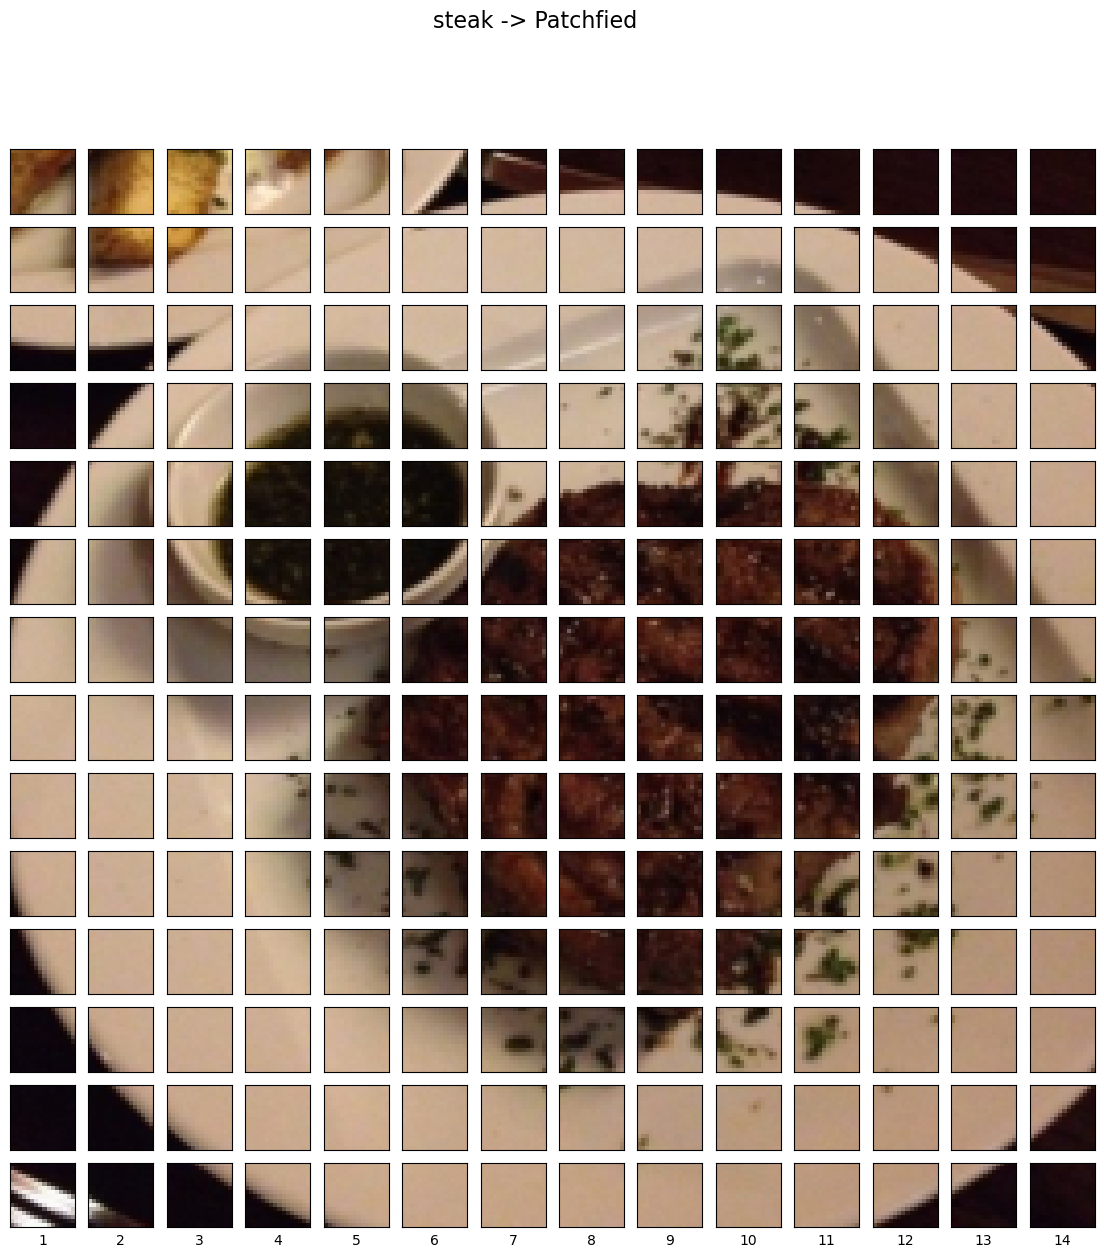

In [27]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image patch (image_permuted -> (H, W, C)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                         patch_width:patch_width+patch_size:])
        # Set up information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchfied", fontsize=16)
plt.show()

In [28]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

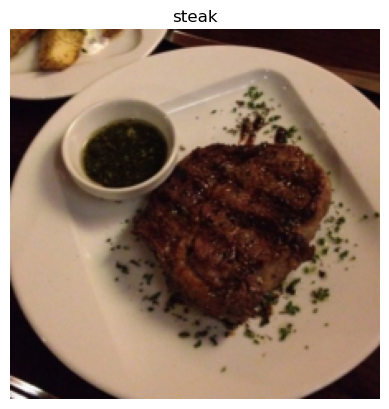

In [29]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [32]:
image_out_of_conv = conv2d(image.unsqueeze(0))  # add a singel batch dim
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [376, 157, 362, 47, 65]


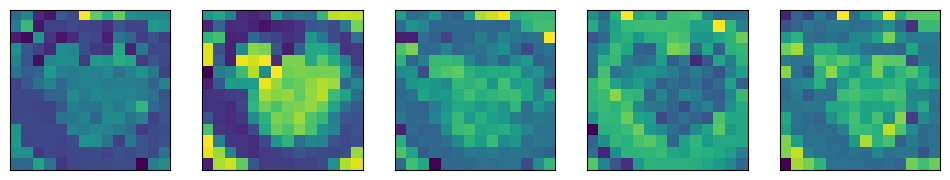

In [34]:
# PLot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [37]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 1.4840e-02, -1.4198e-02,  2.6333e-02,  1.2168e-03, -4.1942e-02,
           -1.2353e-01,  4.3720e-03,  1.4143e-01,  1.3515e-01,  3.1735e-02,
            1.5223e-01, -2.6627e-02, -2.7300e-02, -2.5421e-02],
          [-8.7375e-02, -7.6302e-02,  4.9463e-02, -1.1686e-01, -1.2122e-01,
           -1.2431e-01, -1.3476e-01, -1.3255e-01, -1.5274e-01, -1.9307e-01,
           -1.4848e-01,  9.0184e-02,  5.0544e-02,  1.8854e-02],
          [-2.9591e-01, -3.3378e-01, -9.4716e-02, -1.6216e-01, -1.8406e-01,
           -2.0056e-01, -1.4065e-01, -1.0084e-01, -1.0066e-01, -1.1601e-01,
           -1.1708e-01, -1.6023e-01, -1.3364e-01, -4.8997e-02],
          [-1.3039e-02,  1.8203e-01, -1.3440e-01, -1.9691e-01, -1.6998e-01,
           -1.5309e-01, -1.7346e-01, -9.3068e-02, -1.7901e-01, -1.5909e-01,
           -8.2298e-02, -1.3017e-01, -1.2880e-01, -1.2557e-01],
          [ 3.6004e-02, -1.8254e-01, -2.0503e-01, -1.7986e-02, -4.3247e-02,
           -3.3478e-02, -1.1163e-01, -2.8686e-01, -2.3964e-0